## Setting up enviroment

In [ ]:
import os
import csv
import random
import time
import logging
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score, matthews_corrcoef
from lightgbm import LGBMClassifier

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s:%(message)s')
logger = logging.getLogger(__name__)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [ ]:
data_path = Path('/content/processed_df.csv')
model_path = Path('/content/ae_model.keras')
encoder_path = Path('/content/encoder_model.keras')
log_csv = Path('/content/results.csv')

assert data_path.exists(), f"Data file not found: {data_path}"
assert model_path.exists(), f"Model file not found: {model_path}"
assert encoder_path.exists(), f"Encoder file not found: {encoder_path}"

In [ ]:
logger.info("Loading data and autoencoder model...")
df = pd.read_csv(data_path)
ae = load_model(model_path)
encoder = load_model(encoder_path)

## Fine-tuning classification model

In [ ]:
y = df['Class'].values
X = df.drop('Class', axis=1).values

scaler = StandardScaler().fit(X)

In [ ]:
def extract_features(X):
  X_scaled = scaler.transform(X)
  reconstructed = ae.predict(X_scaled, batch_size=1024)
  error = np.mean(np.abs(X_scaled - reconstructed), axis=1).reshape(-1,1)
  latent = encoder.predict(X_scaled, batch_size=1024)
  return np.hstack([latent, error])

X_feat = extract_features(X)

279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
with open(log_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow([
        'fold',
        'lgbm_best_params',
        'rf_best_params',
        'threshold',
        'Accuracy', 'TPR', 'TNR', 'F1', 'MCC'
    ])

In [ ]:
def split_train_calib(X_train_full, y_train_full, test_size=0.2, random_state=None):
  return train_test_split(X_train_full, y_train_full, test_size=test_size, stratify=y_train_full, random_state=random_state)

In [ ]:
def tune_lgbm(X_train, y_train, random_state):
  param_dist = {
      'num_leaves': [20, 30, 40],
      'learning_rate': [0.05, 0.1, 0.2],
      'n_estimators': [50, 100, 150]
  }
  lgbm = LGBMClassifier(class_weight='balanced', random_state=random_state)
  search = RandomizedSearchCV(
      estimator=lgbm,
      param_distributions=param_dist,
      n_iter=6,
      scoring='matthews_corrcoef',
      cv=3,
      random_state=random_state,
      n_jobs=-1
    )
  search.fit(X_train, y_train)
  return search.best_estimator_, search.best_params_

In [ ]:
def tune_rf(X_train, y_train, random_state):
  param_dist = {
      'n_estimators': [50, 100, 150],
      'max_depth': [None, 10, 20],
      'min_samples_split': [2, 5]
  }
  rf = RandomForestClassifier(class_weight='balanced', random_state=random_state)
  search = RandomizedSearchCV(
      estimator=rf,
      param_distributions=param_dist,
      n_iter=6,
      scoring='matthews_corrcoef',
      cv=3,
      random_state=random_state,
      n_jobs=-1
  )
  search.fit(X_train, y_train)
  return search.best_estimator_, search.best_params_

In [ ]:
def build_stacking_classifier(best_lgbm, best_rf):
  stack = StackingClassifier(
      estimators=[('lgbm', best_lgbm), ('rf', best_rf)],
      final_estimator=LogisticRegression(),
      cv=3,
      n_jobs=-1,
      passthrough=False
  )
  return stack

In [ ]:
def calibrate(stack, X_calib, y_calib):
  prob_calib = stack.predict_proba(X_calib)[:, 1]
  calibrator = LogisticRegression().fit(prob_calib.reshape(-1, 1), y_calib)
  return calibrator, prob_calib

In [ ]:
def find_best_threshold(prob_calib, y_calib):
  thresholds = np.linspace(0, 1, 200)
  mccs = [matthews_corrcoef(y_calib, (prob_calib >= t).astype(int)) for t in thresholds]
  best_t = thresholds[np.argmax(mccs)]
  return best_t

In [ ]:
def evaluate_model(stack, calibrator, X_test, y_test, best_t):
  prob_test = stack.predict_proba(X_test)[:,1]
  prob_test_cal = calibrator.predict_proba(prob_test.reshape(-1,1))[:,1]
  y_pred = (prob_test_cal >= best_t).astype(int)

  acc = accuracy_score(y_test, y_pred)
  tpr = recall_score(y_test, y_pred)
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
  tnr = tn / (tn + fp)
  f1 = f1_score(y_test, y_pred)
  mcc = matthews_corrcoef(y_test, y_pred)
  return acc, tpr, tnr, f1, mcc

In [ ]:
def log_results(log_csv, fold, lgbm_params, rf_params, best_t, acc, tpr, tnr, f1, mcc):
  with open(log_csv, 'a', newline='') as f:
      writer = csv.writer(f)
      writer.writerow([fold, lgbm_params, rf_params, best_t, acc, tpr, tnr, f1, mcc])

In [ ]:
def plot_calibration_curve(prob_calib, y_calib, fold):
  frac_pos, mean_pred = calibration_curve(y_calib, prob_calib, n_bins=10)
  plt.figure(figsize=(6, 4))
  plt.plot(mean_pred, frac_pos, marker='o', label=f'Fold {fold}')
  plt.plot([0, 1], [0, 1], linestyle='--', label='Ideal')
  plt.xlabel('Mean Predicted Probability')
  plt.ylabel('Fraction of Positives')
  plt.title(f'Calibration Curve - Fold {fold}')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

## Training classification model

[LightGBM] [Info] Number of positive: 314, number of negative: 181962
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 182276, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

Fold 1 - Best LGBM:
LGBMClassifier(class_weight='balanced', learning_rate=0.2, num_leaves=20,
               random_state=42)

Fold 1 - Best Random Forest:
RandomForestClassifier(class_weight='balanced', min_samples_split=5,
                       n_estimators=50, random_state=42)
Fold 1 - Best Threshold: 0.246


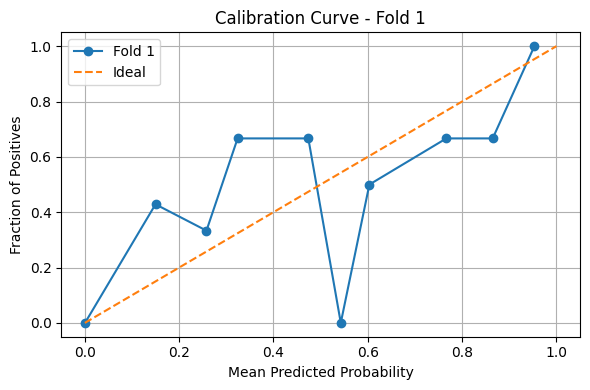

[LightGBM] [Info] Number of positive: 314, number of negative: 181962
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 182276, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

Fold 2 - Best LGBM:
LGBMClassifier(class_weight='balanced', learning_rate=0.2, num_leaves=20,
               random_state=42)

Fold 2 - Best Random Forest:
RandomForestClassifier(class_weight='balanced', n_estimators=50,
                       random_state=42)
Fold 2 - Best Threshold: 0.372


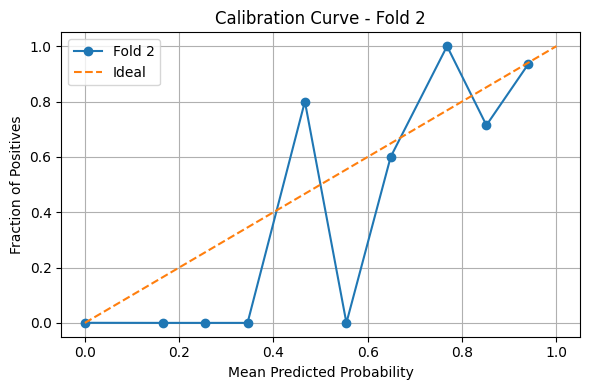

[LightGBM] [Info] Number of positive: 315, number of negative: 181961
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 182276, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

Fold 3 - Best LGBM:
LGBMClassifier(class_weight='balanced', learning_rate=0.2, num_leaves=20,
               random_state=42)

Fold 3 - Best Random Forest:
RandomForestClassifier(class_weight='balanced', min_samples_split=5,
                       n_estimators=150, random_state=42)
Fold 3 - Best Threshold: 0.658


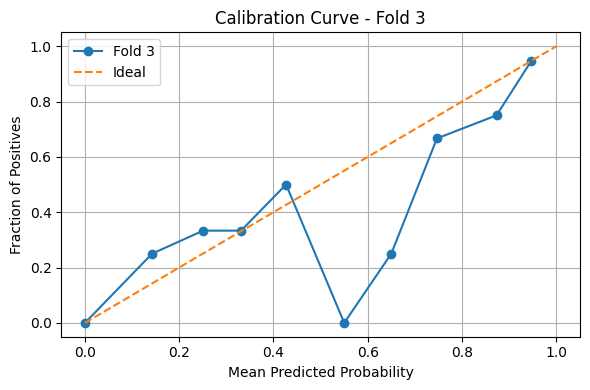

[LightGBM] [Info] Number of positive: 315, number of negative: 181961
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 182276, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

Fold 4 - Best LGBM:
LGBMClassifier(class_weight='balanced', learning_rate=0.2, num_leaves=20,
               random_state=42)

Fold 4 - Best Random Forest:
RandomForestClassifier(class_weight='balanced', n_estimators=50,
                       random_state=42)
Fold 4 - Best Threshold: 0.417


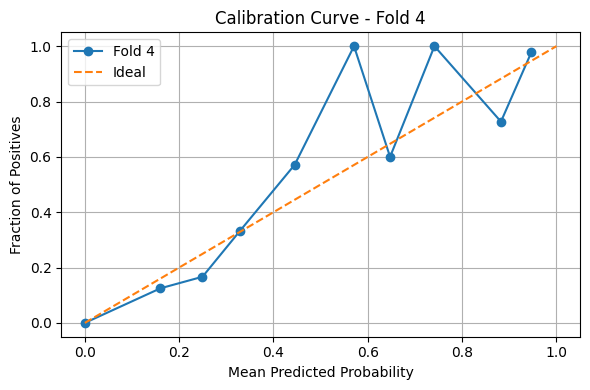

[LightGBM] [Info] Number of positive: 315, number of negative: 181961
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 182276, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

Fold 5 - Best LGBM:
LGBMClassifier(class_weight='balanced', learning_rate=0.2, num_leaves=20,
               random_state=42)

Fold 5 - Best Random Forest:
RandomForestClassifier(class_weight='balanced', random_state=42)
Fold 5 - Best Threshold: 0.533


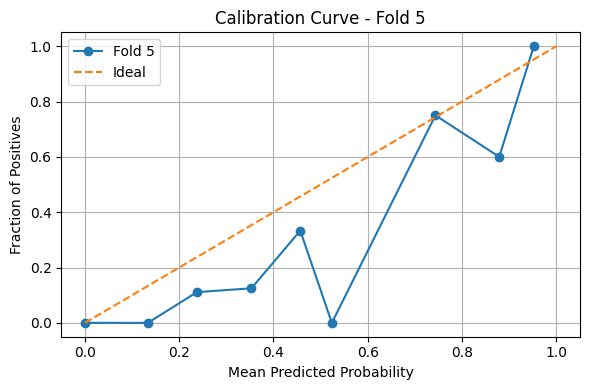

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for fold, (train_idx, test_idx) in enumerate(skf.split(X_feat, y), 1):
  logger.info(f"--- Fold {fold} ---")

  X_train_full, y_train_full = X_feat[train_idx], y[train_idx]
  X_test, y_test = X_feat[test_idx], y[test_idx]

  X_train, X_calib, y_train, y_calib = split_train_calib(X_train_full, y_train_full, random_state=RANDOM_STATE)

  best_lgbm, lgbm_params = tune_lgbm(X_train, y_train, RANDOM_STATE)
  logger.info(f"Fold {fold} LGBM best params: {lgbm_params}")
  print(f"\nFold {fold} - Best LGBM:\n{best_lgbm}")

  best_rf, rf_params = tune_rf(X_train, y_train, RANDOM_STATE)
  logger.info(f"Fold {fold} RF best params: {rf_params}")
  print(f"\nFold {fold} - Best Random Forest:\n{best_rf}")

  stack = build_stacking_classifier(best_lgbm, best_rf)
  stack.fit(X_train, y_train)

  calibrator, prob_calib = calibrate(stack, X_calib, y_calib)
  best_t = find_best_threshold(prob_calib, y_calib)
  logger.info(f"Fold {fold} best threshold: {best_t:.3f}")
  print(f"Fold {fold} - Best Threshold: {best_t:.3f}")

  acc, tpr, tnr, f1, mcc = evaluate_model(stack, calibrator, X_test, y_test, best_t)

  log_results(log_csv, fold, lgbm_params, rf_params, best_t, acc, tpr, tnr, f1, mcc)

  plot_calibration_curve(prob_calib, y_calib, fold)

In [ ]:
logger.info(f"Results saved to {log_csv}")

In [ ]:
import joblib

joblib.dump(stack,  '/content/stack_model.pkl')
joblib.dump(calibrator, '/content/calibrator.pkl')
joblib.dump(scaler, '/content/scaler.pkl')

['/content/drive/MyDrive/Autoencoders/Credit card fraud detection/scaler.pkl']